In [30]:
#imports and constants

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


BATCH_SIZE = 128
TEST_SIZE = 256

In [2]:
# getting data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, y_train, X_test, y_test = mnist.train.images, \
                                   mnist.train.labels, \
                                   mnist.test.images, \
                                   mnist.test.labels

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [16]:

def get_weights(shape):
    return tf.Variable(tf.random_normal(shape=shape, stddev=0.01))


def get_model_block(input_, w, keep_prob, is_final = False):
    conv = tf.nn.conv2d(input = input_, 
                        filter = w, 
                        strides = [1,1,1,1], 
                        padding = "SAME")
    
    x = tf.nn.relu(conv)
    
    x = tf.nn.max_pool(x, 
                       ksize = [1,2,2,1], 
                       strides=[1,2,2,1],
                       padding = "SAME")
    
    if not is_final:
        x = tf.nn.dropout(x = x, keep_prob=keep_prob)
    return x
    

def get_model(input_, keep_prob_conv, keep_prob_hidden, 
              w1, w2, w3, w4, w_o):
    x1 = get_model_block(input_, w1, keep_prob_conv)
    x2 = get_model_block(x1, w2, keep_prob_conv)
    x3 = get_model_block(x2, w3, keep_prob_hidden, is_final=True)
    
    
    out = tf.layers.Flatten()(x3)
    out = tf.nn.dropout(out, keep_prob=keep_prob_conv)
    out = tf.nn.relu(tf.matmul(out, w4))
    out = tf.nn.dropout(out, keep_prob=keep_prob_hidden)
    out = tf.matmul(out, w_o)
    
    return out
    
    
def get_test(X_test, y_test, batch_size):
    test_ind = np.arange(len(y_test))
    np.random.shuffle(test_ind)
    test_ind = test_ind[:batch_size]
    return X_test[test_ind], y_test[test_ind]
    
    

In [22]:
input_ = tf.placeholder(dtype = "float", 
                        shape = (None, 28, 28, 1), 
                        name = "input")

labels = tf.placeholder(dtype = "float", 
                       shape = (None, 10),
                       name = 'labels')

w1 = get_weights(shape = (3, 3, 1, 32))

w2 = get_weights(shape = (3, 3, 32, 64))

w3 = get_weights(shape = (3, 3, 64, 128))

w4 = get_weights(shape = (2048, 625))

w_o = get_weights(shape = (625, 10))

out = get_model(input_= input_, keep_prob_conv = 0.8, 
                keep_prob_hidden = 0.5,
                  w1 = w1, 
                  w2 = w2, 
                  w3 = w3, 
                  w4 = w4,
                  w_o = w_o)


loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, 
                                                  logits=out)

cost = tf.reduce_mean(loss)

train_op = tf.train.Ada(0.001, 0.9).minimize(cost)

pred_op = tf.argmax(out,  axis=1)

In [26]:
acc_list = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for i in tqdm(range(10)):
        training_batch = zip(range(0, len(X_train), BATCH_SIZE), 
                            range(BATCH_SIZE, len(y_train), BATCH_SIZE))

        for start, end in training_batch:
            sess.run(train_op, feed_dict = {input_: X_train[start:end], 
                                           labels: y_train[start:end]})

        X_t, y_t = get_test(X_test, y_test, TEST_SIZE)
        pred_val = sess.run(pred_op, 
                            feed_dict={input_: X_t, 
                                       labels: y_t})
        
        acc_val = np.mean(pred_val == np.argmax(y_t, 1))
        print("On step {} accuracy {}".format(i, acc_val))
        acc_list.append(acc_val)


 10%|█         | 1/10 [01:06<09:56, 66.32s/it]

On step 0 accuracy 0.9453125


 20%|██        | 2/10 [02:09<08:39, 64.91s/it]

On step 1 accuracy 0.9765625


 30%|███       | 3/10 [03:10<07:24, 63.47s/it]

On step 2 accuracy 0.98828125


 40%|████      | 4/10 [04:10<06:16, 62.74s/it]

On step 3 accuracy 0.99609375


KeyboardInterrupt: 

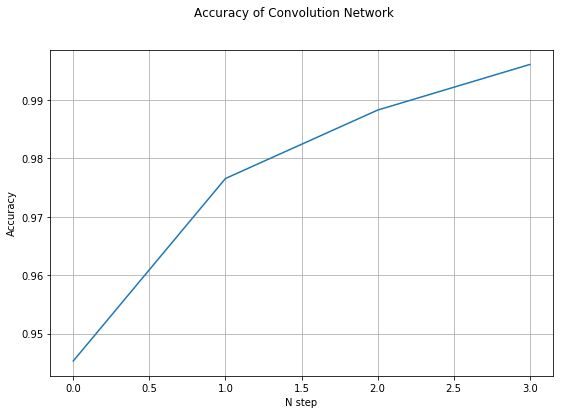

In [36]:
fig = plt.figure(figsize=(9,6))
fig.suptitle('Accuracy of Convolution Network')
ax = fig.add_subplot(111)
ax.set_xlabel('N step', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)  
plt.plot(acc_list)
plt.grid(True)
plt.show()
